<a href="https://colab.research.google.com/github/ammarSherif/KDD-ML-IDS/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML IDS using Random Forest
In this notebook, I will try to achieve high accuracy using the Random Forest model.

## Background

### Problem

Cyberattacks have increased a lot throughout the last few years with our move towards technology. Traditionally, the security field has developed tools to protect against such attacks. One of these tools is the **Intrusion Detection System** (IDS). Its aim is to filter the network trafic to *prevent malicious* attacks. Nevertheless, because attackers always keep changing their tools and techniques, traditional IDS, rule-based ones, become more vulnerable to new attacks and is associated with high development cost. In this notebook, several experiments have been performed trying to build a successful IDS based on KDD intrusion dataset.

### Dataset

I used the **[KDD99](https://www.kdd.org/kdd-cup/view/kdd-cup-1999/Intro)** dataset. It is based on the DARPA Intrusion Detection Evaluation Program, which includes a wide variety of **intrusions** simulated in a military network environment.

## Import Dataset
Previously, I modified the dataset adding a feature header to it, so as to be able to deal with it as a CSV dataset. I will train on the 10% dataset whose name is `kddcup.data_10_percent` on the official website. 

In [1]:
# ================================================================
# Import some needed packages
# ================================================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ================================================================
# Importing the training data from the drive
# ================================================================
f = '/content/drive/MyDrive/Data/IDS/kddcup.data_10_percent'
data10 = pd.read_csv(f)
# ================================================================
# We print its shape
# ================================================================
data10.shape

(494021, 42)

In [3]:
# ================================================================
# Importing a new labeled test data to test our model on it
# ================================================================
f = '/content/drive/MyDrive/Data/IDS/corrected'
testCorrect = pd.read_csv(f)
# ================================================================
# We print its shape
# ================================================================
testCorrect.shape

(311029, 42)

Notice that the labeld test dataset `corrected` includes around **17 new attacks** that were not present in the original training dataset, as seen below. The idea is that security, domain, experts claims that new attacks are similar to the older ones, and our model should be able to detect them as well.

In [4]:
data10.label.unique()

array(['normal.', 'buffer_overflow.', 'loadmodule.', 'perl.', 'neptune.',
       'smurf.', 'guess_passwd.', 'pod.', 'teardrop.', 'portsweep.',
       'ipsweep.', 'land.', 'ftp_write.', 'back.', 'imap.', 'satan.',
       'phf.', 'nmap.', 'multihop.', 'warezmaster.', 'warezclient.',
       'spy.', 'rootkit.'], dtype=object)

In [5]:
testCorrect.label.unique()

array(['normal.', 'snmpgetattack.', 'named.', 'xlock.', 'smurf.',
       'ipsweep.', 'multihop.', 'xsnoop.', 'sendmail.', 'guess_passwd.',
       'saint.', 'buffer_overflow.', 'portsweep.', 'pod.', 'apache2.',
       'phf.', 'udpstorm.', 'warezmaster.', 'perl.', 'satan.', 'xterm.',
       'mscan.', 'processtable.', 'ps.', 'nmap.', 'rootkit.', 'neptune.',
       'loadmodule.', 'imap.', 'back.', 'httptunnel.', 'worm.',
       'mailbomb.', 'ftp_write.', 'teardrop.', 'land.', 'sqlattack.',
       'snmpguess.'], dtype=object)

In [6]:
# ================================================================
# Print the attacks not in the previous dataset
# ================================================================
newAttacks = set(testCorrect.label.unique())- set(
                 data10.label.unique())
print(newAttacks)
print(len(newAttacks))

{'xsnoop.', 'saint.', 'xlock.', 'ps.', 'sendmail.', 'snmpguess.', 'snmpgetattack.', 'xterm.', 'sqlattack.', 'httptunnel.', 'mscan.', 'processtable.', 'worm.', 'mailbomb.', 'apache2.', 'udpstorm.', 'named.'}
17


## Feature Engineering
Now, we will manipulate the features to increase the efficiency of the training. Nevertheless, in order to do so, we first check some information about the data as below:

In [7]:
# ================================================================
# Check the datatypes
# ================================================================
data10.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

### Feature Selection

#### Using Variance
We remove the 0 variance features

In [8]:
# ================================================================
# Check the variance of numeric features
# ================================================================
data10.var()

duration                       5.009051e+05
src_bytes                      9.765750e+11
dst_bytes                      1.091642e+09
land                           4.453063e-05
wrong_fragment                 1.817245e-02
urgent                         3.036294e-05
hot                            6.116844e-01
num_failed_logins              2.408579e-04
logged_in                      1.262699e-01
num_compromised                3.233977e+00
root_shell                     1.113191e-04
su_attempted                   6.072496e-05
num_root                       4.051035e+00
num_file_creations             9.296022e-03
num_shells                     1.214406e-04
num_access_files               1.330914e-03
num_outbound_cmds              0.000000e+00
is_host_login                  0.000000e+00
is_guest_login                 1.384661e-03
count                          4.543182e+04
srv_count                      6.067493e+04
serror_rate                    1.449454e-01
srv_serror_rate                1

As we see, some features have very little variance. We remove them because we believe they do not contribute to our learning model

In [9]:
# ================================================================
# We return the number of non-object features below the  threshold
# ----------------------------------------------------------------
# We could have used VarianceThreshold module instead,  yet we did
# it anyhow.
# ================================================================
def colBelowThre(data,threshold):
  belowThre = []
  for col in list(data.columns):
    if data.dtypes[col] !='object' and data[col].var()<=threshold:
      belowThre.append(col)
  return belowThre

In [10]:
# ================================================================
# Print the features whose variance is below the threshold
# ================================================================
threshold = 0.1
belowThre = colBelowThre(data10,threshold)
for col in belowThre:
  print(col)
  print(data10[col].value_counts()/len(data10))
  print('\n')
print("The number of features: "+str(len(belowThre)))

land
0    0.999955
1    0.000045
Name: land, dtype: float64


wrong_fragment
0    0.997494
3    0.001963
1    0.000542
Name: wrong_fragment, dtype: float64


urgent
0    0.999992
1    0.000004
3    0.000002
2    0.000002
Name: urgent, dtype: float64


num_failed_logins
0    0.999872
1    0.000115
2    0.000006
5    0.000002
4    0.000002
3    0.000002
Name: num_failed_logins, dtype: float64


root_shell
0    0.999889
1    0.000111
Name: root_shell, dtype: float64


su_attempted
0    0.999976
2    0.000012
1    0.000012
Name: su_attempted, dtype: float64


num_file_creations
0     0.999464
1     0.000419
2     0.000073
4     0.000014
16    0.000004
9     0.000002
5     0.000002
7     0.000002
8     0.000002
28    0.000002
25    0.000002
12    0.000002
14    0.000002
15    0.000002
20    0.000002
21    0.000002
22    0.000002
10    0.000002
Name: num_file_creations, dtype: float64


num_shells
0    0.999897
1    0.000097
2    0.000006
Name: num_shells, dtype: float64


num_access_files
0

In [11]:
# ================================================================
# Delete the below threshold features
# ================================================================
data10Mod = data10.copy()
# dataTstMod= testCorrect.copy()
# datasets = [data10Mod,dataTstMod]
# for d in datasets:
for col in belowThre:
    del data10Mod[col]
# ================================================================
# Delete having 0 variance in the original data
# ================================================================
datasets = [data10,testCorrect]
zeroVar = colBelowThre(data10,0)
for d in datasets:
  for col in zeroVar:
    del d[col]

In [12]:
# ================================================================
# Show the differences in the number of features:
# ================================================================
print("Original features [10%]: "+str(len(data10.columns)))
print("Selected features [10%]: "+str(len(data10Mod.columns)))
print("Original features [new]: "+str(len(testCorrect.columns)))
# print("Selected features [new]: "+str(len(dataTstMod.columns)))
print("Number of removed features: "+str(len(belowThre)))

Original features [10%]: 40
Selected features [10%]: 22
Original features [new]: 40
Number of removed features: 20


#### Using Correlation

In [13]:
# ================================================================
# Define a function to plot the heatmap
# ================================================================
def plotHeatmap(data):
  corr = data.corr()
  plt.figure(figsize=(15,12))
  sns.heatmap(corr)
  plt.show()

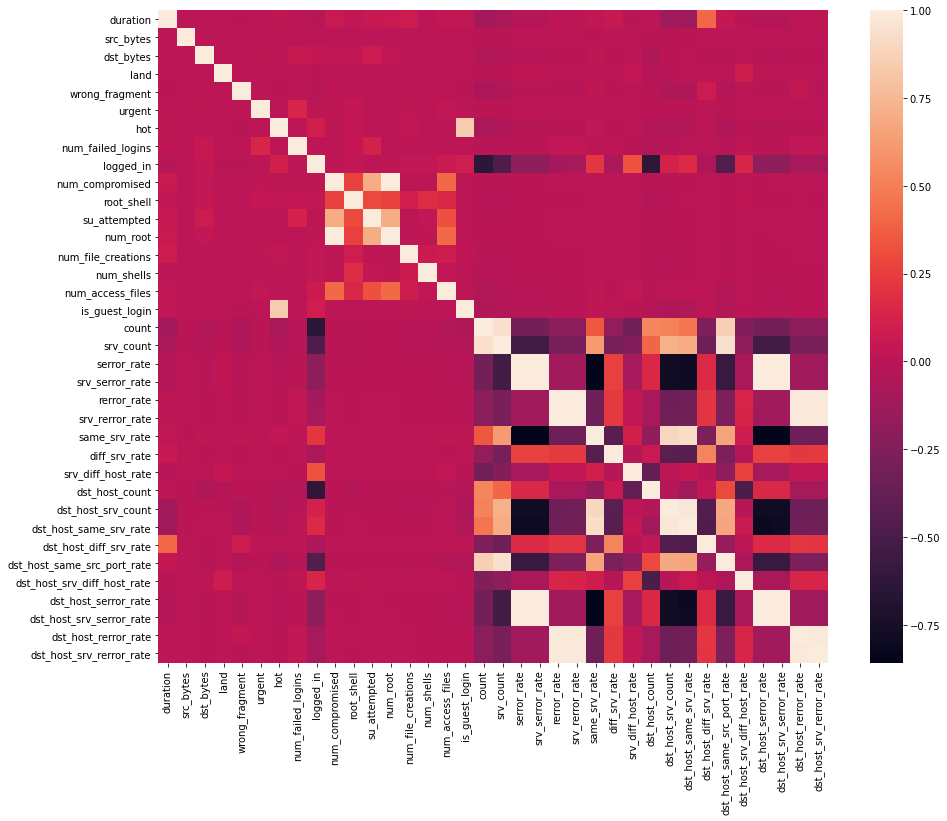

In [14]:
# ================================================================
# Plotting the  correlation heatmap  of both the modified and ori-
# ginal
# ================================================================
plotHeatmap(data10)

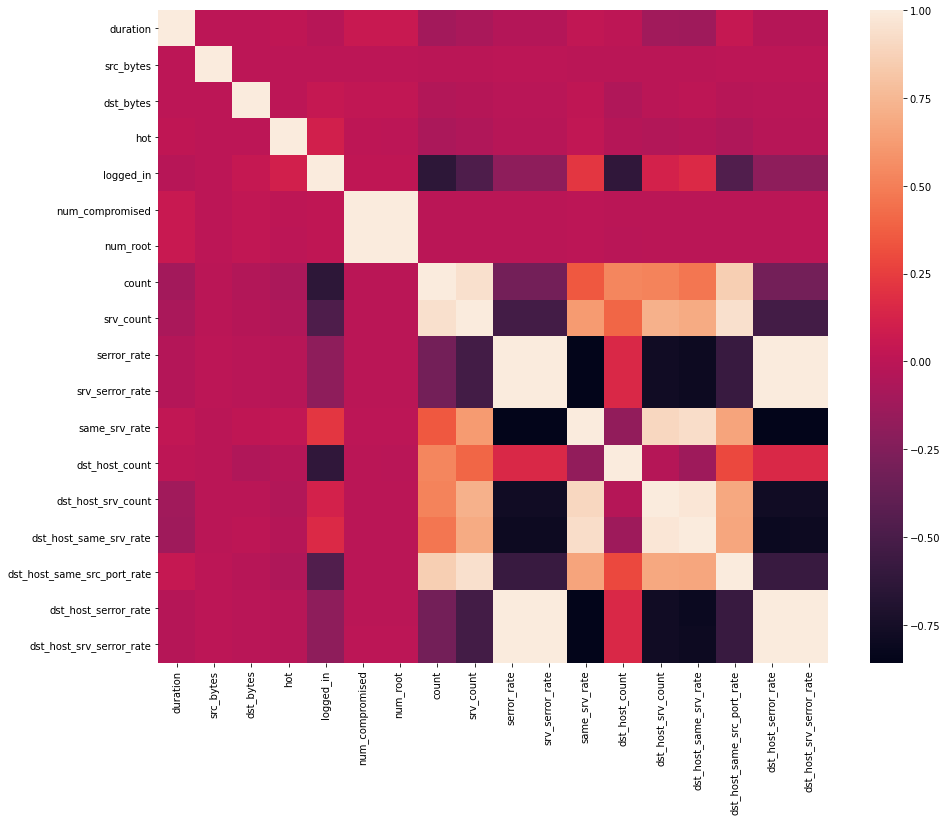

In [15]:
plotHeatmap(data10Mod)

In [16]:
# ================================================================
# Now, as we see we would like to further remove these  correlated
# features.
# ================================================================
def getCorrelated(data,threshold):
  # ==============================================================
  # compute the absolute correlation matrix. Notice we do not care
  # about the sign of the correlation. We only care whether a fea-
  # ture provides information about another feature or not.
  # ==============================================================
  corrMat = data.corr().abs()
  # ==============================================================
  # We compute get the upper triangular form of the matrix,  so as
  # to discard the duplicated data
  # ==============================================================
  upper = corrMat.where(np.triu(np.ones(corrMat.shape), 
                                k=1).astype(np.bool))
  # ==============================================================
  # Loop over the columns/rows and add the column that has a value
  # above the threshold
  # ==============================================================
  return [col for col in upper.columns if any(
      upper[col] >= threshold)]

In [17]:
threshold = 0.9
corrColumn = getCorrelated(data10Mod,threshold)
# datasets = [data10Mod,dataTstMod]
# for d in datasets:
for col in corrColumn:
    del data10Mod[col]

In [18]:
# ================================================================
# Print the number of removed columns and the new shapes
# ================================================================
print("Number of removed columns: "+str(len(corrColumn)))
print("Correlated columns:",corrColumn)
print(data10Mod.shape)
# print(dataTstMod.shape)

Number of removed columns: 7
Correlated columns: ['num_root', 'srv_count', 'srv_serror_rate', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate']
(494021, 15)


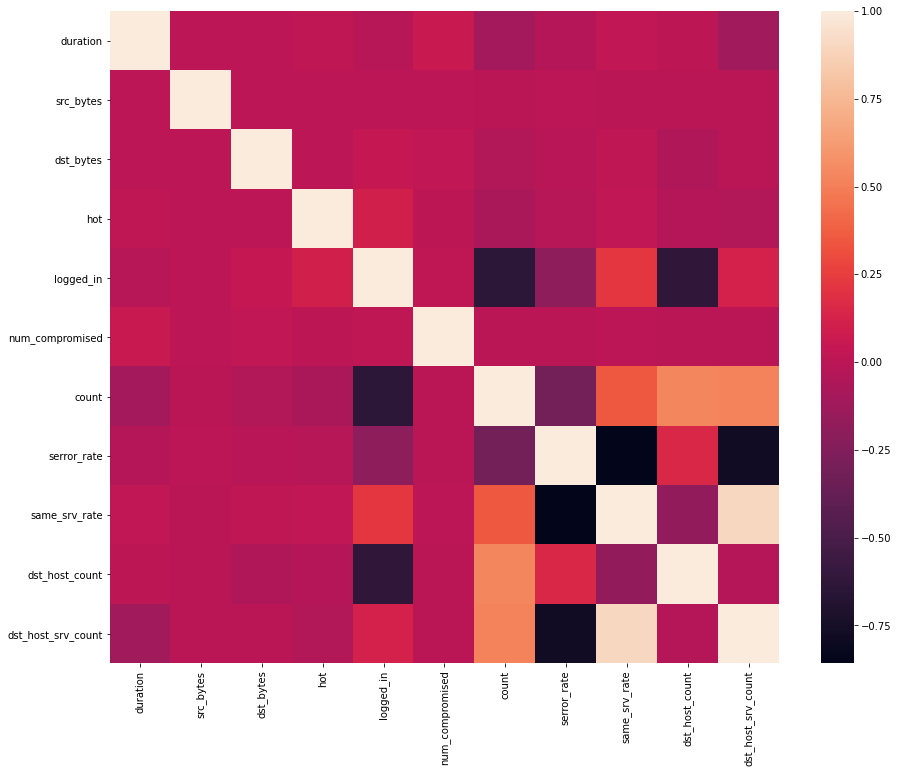

In [19]:
# ================================================================
# Show the heatmap of the correlation
# ================================================================
plotHeatmap(data10Mod)

#### Removed Features

In [20]:
# ================================================================
# Get the total removed features
# ================================================================
delFeatures = belowThre+corrColumn
print(delFeatures)
print(len(delFeatures))

['land', 'wrong_fragment', 'urgent', 'num_failed_logins', 'root_shell', 'su_attempted', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'rerror_rate', 'srv_rerror_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_diff_srv_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'num_root', 'srv_count', 'srv_serror_rate', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate']
27


### New attacks records
While testing we would like also to check the performance of our model in the unseen attacks; therefore, we copy them as below.

In [21]:
newRecords = testCorrect.loc[testCorrect['label'].isin(
                            newAttacks)].copy()
# newMod = dataTstMod.loc[dataTstMod['label'].isin(
#                             newAttacks)].copy()
print(newRecords.shape)
# print(newMod.shape)

(18729, 40)


In [22]:
# ================================================================
# Make sure  it equals the  new ones.
# ================================================================
print('Equal new attacks:',set(newRecords.label.unique()
                              ) == newAttacks)
# print('Equal new attacks:',set(newMod.label.unique()
#                               ) == newAttacks)

Equal new attacks: True


### Replicating Datasets
As we are about to label the values to train it with our model, we copy it first.

In [23]:
dTrain = data10.copy()
dTest  = testCorrect.copy()
dNewTst= newRecords.copy()
# ================================================================
# Remove the unnecessary data10Mod
# ================================================================
del data10Mod
# dTestM  = dataTstMod.copy()
# dNewTstM= newMod.copy()

### Categorical Features [Label Encoding]
Notice we have some categorical features like `protocol_type,service,` and `flag`. Nevertheless, because we will use a **tree-based** model (Random Forest), we do encode the values using **label encoding**, as it would not affect the training of our model. In case, we are using Neural Network, for example, we might have used one of the below techniques:
- Embedding
- Dummy encoding


In [24]:
# ================================================================
# Get the indices of categorical features
# ================================================================
objList = list(testCorrect.select_dtypes(
                include = "object").columns)[:-1]
print(objList)

['protocol_type', 'service', 'flag']


In [25]:
# ================================================================
# Store the size of original dataset
# ================================================================
s1 = len(dTrain)
s2 = len(dTest)
s3 = len(dNewTst)
# ================================================================
# Merge the two datasets to label them uniquely.
# ----------------------------------------------------------------
# Note if we labeled  them indiviually, an item  'A' might have  a
# label 0 in one dataset and 2 in another.  This will make it  in-
# appropriate to test the model on the other dataset.
# ================================================================
data = dTrain.append(dTest).append(dNewTst)
# data2= dTrainM.append(dTestM).append(dNewTstM)

In [26]:
# ================================================================
# Create label encoding, to train it later on
# ================================================================
le = LabelEncoder()
for feature in objList:
  data[feature] = le.fit_transform(data[feature])
  # data2[feature] = le.fit_transform(data2[feature])

In [27]:
# ================================================================
# Split them again
# ================================================================
dTrain = data.iloc[:s1,:].copy()
dTest  = data.iloc[s1:(s1+s2),:].copy()
dNewTst= data.iloc[(s1+s2):,:].copy()

# dTrainM = data2.iloc[:s1,:].copy()
# dTestM  = data2.iloc[s1:(s1+s2),:].copy()
# dNewTstM= data2.iloc[(s1+s2):,:].copy()

In [28]:
# ================================================================
# Define a function to clean the data
# ================================================================
def cleanDF(data,cols):
  # ==============================================================
  # Get the available features to be removed
  # ==============================================================
  rmFeatures = list(set(cols).intersection(set(data.columns)))
  # ==============================================================
  # We clone it first, and delete the features
  # ==============================================================
  df = data.copy()
  for col in rmFeatures:
    del df[col]
  # ==============================================================
  # Return the final dataframe
  # ==============================================================
  return df

## Training [Malicious vs Normal]
Now, we will train our model using all the features to detect whether a record is normal or malicious. Therefore, we first encode the labels into $0,1$

In [29]:
# ================================================================
# Clone the new and test datasets and clean the features
# ================================================================
dTestM = cleanDF(dTest,delFeatures)
dNewTstM = cleanDF(dNewTst,delFeatures)

print(dTest.shape)
print(dTestM.shape)

(311029, 40)
(311029, 15)


In [30]:
# ================================================================
# Encode the labels into 0 for normal, 1 otherwise
# ================================================================
datasets = [dTrain,dTest,dNewTst,dTestM,dNewTstM] #dTrainM
labelDic = ['Normal','Malicious']
for d in datasets:
  d['label'] = d['label'].map(lambda x: 0 if x =='normal.' else 1)

In [31]:
print(dTrain.label.value_counts()/len(dTrain))
print(dTest.label.value_counts()/len(dTest))
print(dNewTst.label.value_counts()/len(dNewTst))

# print(dTrainM.label.value_counts()/len(dTrainM))
print(dTestM.label.value_counts()/len(dTestM))
print(dNewTstM.label.value_counts()/len(dNewTstM))

1    0.803089
0    0.196911
Name: label, dtype: float64
1    0.805185
0    0.194815
Name: label, dtype: float64
1    1.0
Name: label, dtype: float64
1    0.805185
0    0.194815
Name: label, dtype: float64
1    1.0
Name: label, dtype: float64


In [32]:
# ================================================================
# The function splits the features from the target
# ================================================================
def splitTarget(df):
  colNum = len(df.columns)
  return df.iloc[:,colNum-1].copy(),df.iloc[:,0:colNum-1].copy()

In [33]:
# ================================================================
# Split the data from the target label
# ================================================================
y,x = splitTarget(dTrain)
yT,xT = splitTarget(dTest)
yN,xN = splitTarget(dNewTst)
# ================================================================
# Split the modified features
# ================================================================
# y2,x2 = splitTarget(dTrainM)
yT2,xT2 = splitTarget(dTestM)
yN2,xN2 = splitTarget(dNewTstM)

In [34]:
# ================================================================
# Split the training features to have 30% for testing and  70% for
# training.
# ================================================================
x_train,x_test,y_train,y_test = train_test_split(x,y, 
                                                 test_size = 0.30)

# ================================================================
# Clone the  training/testing  and remove the unnecessary features
# ================================================================
x_train2 = cleanDF(x_train,delFeatures)
x_test2 = cleanDF(x_test,delFeatures)
y_train2 = y_train
y_test2 = y_test

In [35]:
# ================================================================
# Train our model based on the training part from the 
# ================================================================
rf = RandomForestClassifier(n_estimators = 100,n_jobs=-1,
                            class_weight = 'balanced_subsample',
                            verbose=0)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [36]:
# ================================================================
# Train on the slected features only
# ================================================================
rf2 = RandomForestClassifier(n_estimators = 100,n_jobs=-1,
                             class_weight = 'balanced_subsample',
                             verbose=0)
rf2.fit(x_train2, y_train2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Model Accuracy

In [37]:
print("::::Using all the features::::")
y_pred = rf.predict(x_test)
print("Accuracy [d1]: ", metrics.accuracy_score(y_test, y_pred))
y_pred = rf.predict(xT)
print("Accuracy [d2]: ", metrics.accuracy_score(yT, y_pred))
y_pred = rf.predict(xN)
print("Accuracy [d3]: ", metrics.accuracy_score(yN, y_pred))
print("\n::::Using the selected features::::")
y_pred = rf2.predict(x_test2)
print("Accuracy [d1]: ", metrics.accuracy_score(y_test2, y_pred))
y_pred = rf2.predict(xT2)
print("Accuracy [d2]: ", metrics.accuracy_score(yT2, y_pred))
y_pred = rf2.predict(xN2)
print("Accuracy [d3]: ", metrics.accuracy_score(yN2, y_pred))

::::Using all the features::::
Accuracy [d1]:  0.9998380643289453
Accuracy [d2]:  0.9287301184133956
Accuracy [d3]:  0.10454375567302045

::::Using the selected features::::
Accuracy [d1]:  0.999831317009318
Accuracy [d2]:  0.926739950294024
Accuracy [d3]:  0.1280901276095894


### Model F-Score


In [38]:
print("::::Using all the features::::")
y_pred = rf.predict(x_test)
print("F-Score [d1]: ", metrics.f1_score(y_test, y_pred))
y_pred = rf.predict(xT)
print("F-Score [d2]: ", metrics.f1_score(yT, y_pred))
y_pred = rf.predict(xN)
print("F-Score [d3]: ", metrics.f1_score(yN, y_pred))
print("\n::::Using the selected features::::")
y_pred = rf2.predict(x_test2)
print("F-Score [d1]: ", metrics.f1_score(y_test2, y_pred))
y_pred = rf2.predict(xT2)
print("F-Score [d2]: ", metrics.f1_score(yT2, y_pred))
y_pred = rf2.predict(xN2)
print("F-Score [d3]: ", metrics.f1_score(yN2, y_pred))

::::Using all the features::::
F-Score [d1]:  0.9998990884321706
F-Score [d2]:  0.9537537161633546
F-Score [d3]:  0.18929762652873786

::::Using the selected features::::
F-Score [d1]:  0.9998948815735809
F-Score [d2]:  0.9524546789970956
F-Score [d3]:  0.22709201060204467


### Confusion Matrix
Below, we plot the confusion matrix

In [39]:
def normRow(mat):
  return mat/np.sum(mat,axis=1,keepdims=True)
# ================================================================
# Confusion matrix of testing
# ================================================================
def plotConfMat(yTrue,yPred,title,norm=False,cols=None,indx=None):
  confMat = metrics.confusion_matrix(y_true=yTrue,y_pred= yPred)
  if norm:
    # ============================================================
    # We normalize the confMat if wanted
    # ============================================================
    confMat = normRow(confMat)
    title += " (Normalized)"
  confMat = pd.DataFrame(confMat,index=indx, columns=cols)
  plt.figure(figsize=(15,12))
  sns.heatmap(confMat,annot=True)
  plt.xlabel('Predicted',fontsize='xx-large')
  plt.ylabel('True',fontsize='xx-large')
  plt.title(title,fontsize='xx-large')
  plt.show()

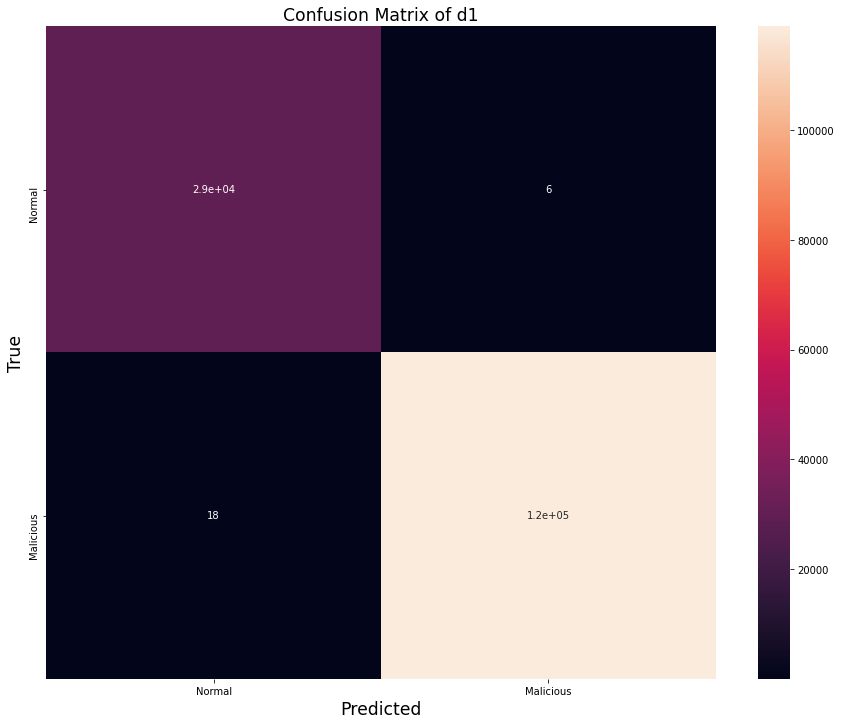

In [40]:
y_pred = rf.predict(x_test)
plotConfMat(y_test,y_pred,"Confusion Matrix of d1",cols=labelDic,
            indx=labelDic)

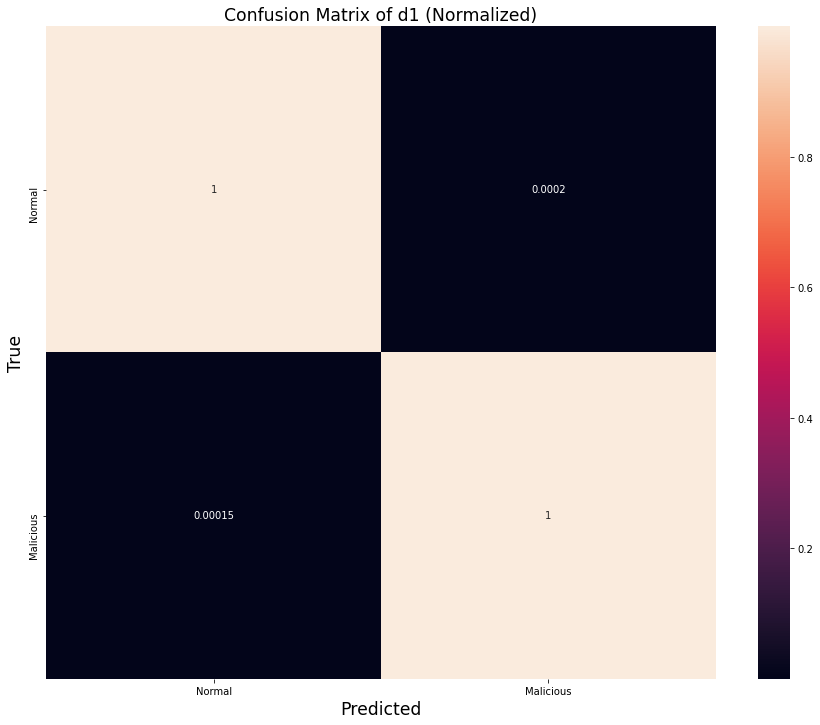

In [41]:
plotConfMat(y_test,y_pred,"Confusion Matrix of d1",True,cols=labelDic,
            indx=labelDic)

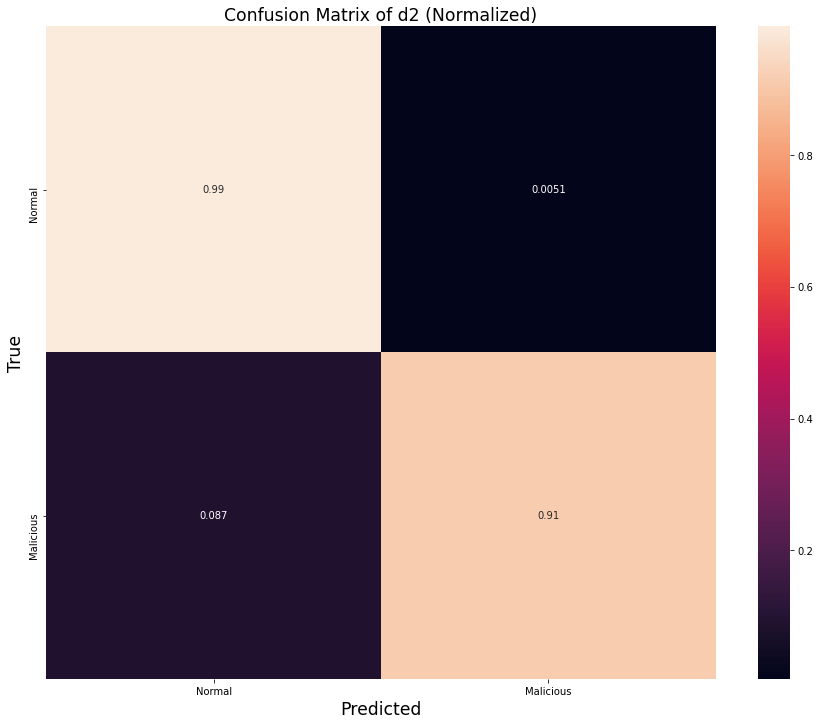

In [42]:
y_pred = rf.predict(xT)
plotConfMat(yT,y_pred,"Confusion Matrix of d2",True,cols=labelDic,
            indx=labelDic)

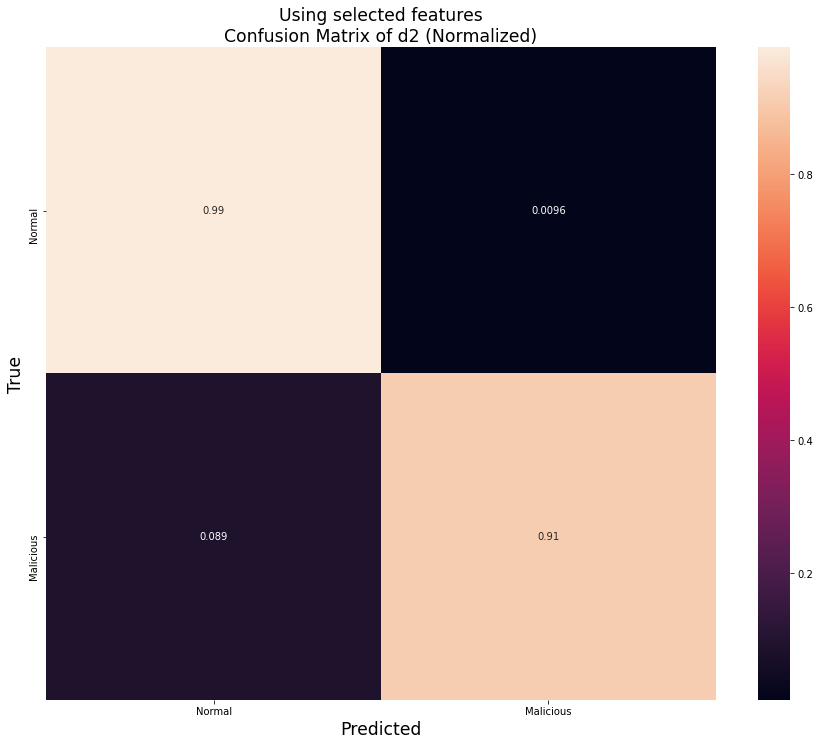

In [43]:
y_pred2 = rf2.predict(xT2)
plotConfMat(yT2,y_pred2,"Using selected features\nConfusion Matrix of d2",True,
            cols=labelDic, indx=labelDic)

## Training [Categories]
Now, we will train our model using all the features to detect whether a record lies in the below categories as below:

<table style="width: 80%">
  <tr>
    <th>Category</th>
    <th>Attack Name</th>
    <th>Category</th>
    <th>Attack Name</th>
    <th>Category</th>
    <th>Attack Name</th>
    <th>Category</th>
    <th>Attack Name</th>
  </tr>
  <tr>
    <td rowspan="8"><center>DOS</center></td>
    <td align='center'>smurf</td>
    <td rowspan="8"><center>U2R</center></td>
    <td align='center'>buffer_overflow</td>
    <td rowspan="8"><center>R2L</center></td>
    <td align='center'>ftp_write</td>
    <td rowspan="8"><center>PROBE</center></td>
    <td align='center'>ipsweep</td>
  </tr>
  <tr>
    <td align='center'>neptune</td>
    <td align='center'>loadmodule</td>
    <td align='center'>guess_passwd</td>
    <td align='center'>nmap</td>
  </tr>
  <tr>
    <td align='center'>back</td>
    <td align='center'>perl</td>
    <td align='center'>imap</td>
    <td align='center'>portsweep</td>
  </tr>
  <tr>
    <td align='center'>pod</td>
    <td align='center'>rootkit</td>
    <td align='center'>multihop</td>
    <td align='center'>satan</td>
  </tr>
  <tr>
    <td align='center'>teardrop</td>
    <td align='center'>&nbsp;</td>
    <td align='center'>phf</td>
    <td align='center'>&nbsp;</td>
  </tr>
  <tr>
    <td align='center'>land</td>
    <td align='center'>&nbsp;</td>
    <td align='center'>spy</td>
    <td align='center'>&nbsp;</td>
  </tr>
  <tr>
    <td align='center'>&nbsp;</td>
    <td align='center'>&nbsp;</td>
    <td align='center'>warezclient</td>
    <td align='center'>&nbsp;</td>
  </tr>
  <tr>
    <td align='center'>&nbsp;</td>
    <td align='center'>&nbsp;</td>
    <td align='center'>warezmaster</td>
    <td align='center'>&nbsp;</td>
  </tr>
  <tr>
</table>
<!-- array(['normal.', 'buffer_overflow.', 'loadmodule.', 'perl.', 'neptune.',
       'smurf.', 'guess_passwd.', 'pod.', 'teardrop.', 'portsweep.',
       'ipsweep.', 'land.', 'ftp_write.', 'back.', 'imap.', 'satan.',
       'phf.', 'nmap.', 'multihop.', 'warezmaster.', 'warezclient.',
       'spy.', 'rootkit.'], dtype=object) -->

<!-- | Category | Attack Name |
| :-: | :-: |
| DOS | smurf. | -->

In [44]:
# ================================================================
# Define the mapping table of attack categories
# ================================================================
attackMap = {
    'normal.':'normal', 'smurf.':'dos', 'neptune.':'dos',
    'back.':'dos', 'pod.':'dos', 'teardrop.':'dos', 'land.':'dos',
    'buffer_overflow.':'u2r', 'loadmodule.':'u2r', 'perl.':'u2r',
    'rootkit.':'u2r', 'ftp_write.':'r2l', 'guess_passwd.':'r2l',
    'imap.':'r2l', 'multihop.':'r2l', 'phf.':'r2l', 'spy.':'r2l',
    'warezclient.':'r2l', 'warezmaster.':'r2l',
    'ipsweep.':'probe', 'nmap.':'probe', 'portsweep.':'probe',
    'satan.':'probe',
}
mapCategory = {
    'normal':0, 'dos':1, 'u2r':2, 'r2l':3,'probe':4,'other':5}

# ================================================================
# Define a function to map into malicious/normal
# ================================================================
def mapVal(res,mapper=None):
  if mapper is None:
    return np.array([0 if (x=='normal' or x==0) else 1 for x in res])
  else:
    return np.array([mapper[x] for x in res])

In [45]:
# ================================================================
# Update the label data back
# ================================================================
dTrain['label'] = data10['label']
dTest['label']  = testCorrect['label']
dNewTst['label']= newRecords['label']

# dTrainM['label'] = data10Mod['label']
# dTestM['label']  = dataTstMod['label']
# dNewTstM['label']= newMod['label']
# ================================================================
# Encode the labels into categories
# ================================================================
datasets = [dTrain,dTest,dNewTst]
for d in datasets:
  d['label'] = d['label'].map(lambda x: attackMap[x] if x 
                              in attackMap else 'other')

In [46]:
# ================================================================
# Print the percentage of each attack
# ================================================================
print(dTrain.label.value_counts()/len(dTrain))
print(dTest.label.value_counts()/len(dTest))
print(dNewTst.label.value_counts()/len(dNewTst))

dos       0.792391
normal    0.196911
probe     0.008313
r2l       0.002279
u2r       0.000105
Name: label, dtype: float64
dos       0.717933
normal    0.194815
other     0.060216
r2l       0.019268
probe     0.007642
u2r       0.000125
Name: label, dtype: float64
other    1.0
Name: label, dtype: float64


In [47]:
# ================================================================
# Split the data from the target label
# ================================================================
y,x = splitTarget(dTrain)
y = mapVal(y,mapCategory)
yT,xT = splitTarget(dTest)
yT = mapVal(yT,mapCategory)
yN,xN = splitTarget(dNewTst)
yN = mapVal(yN,mapCategory)

# ================================================================
# Clone the new and test datasets and clean the features
# ================================================================
dTestM = cleanDF(dTest,delFeatures)
dNewTstM = cleanDF(dNewTst,delFeatures)
# ================================================================
# Split the modified features
# ================================================================
yT2,xT2 = splitTarget(dTestM)
yT2 = mapVal(yT2,mapCategory)
yN2,xN2 = splitTarget(dNewTstM)
yN2 = mapVal(yN2,mapCategory)

In [48]:
# ================================================================
# Split the training features to have 30% for testing and  70% for
# training.
# ================================================================
x_train,x_test,y_train,y_test = train_test_split(x,y, 
                                                 test_size = 0.30)

# ================================================================
# Clone the  training/testing  and remove the unnecessary features
# ================================================================
x_train2 = cleanDF(x_train,delFeatures)
x_test2 = cleanDF(x_test,delFeatures)
y_train2 = y_train
y_test2 = y_test

In [49]:
# ================================================================
# Train our model based on the training part from the 
# ================================================================
rf = RandomForestClassifier(n_estimators =100,n_jobs=-1,
                            class_weight = 'balanced_subsample',
                            verbose=0)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [50]:
# ================================================================
# Train on the slected features only
# ================================================================
rf2 = RandomForestClassifier(n_estimators = 100,n_jobs=-1,
                             class_weight = 'balanced_subsample',
                             verbose=0)
rf2.fit(x_train2, y_train2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Model Accuracy

In [51]:
y_pred = rf.predict(x_test)
print("Accuracy [d1]: ", metrics.accuracy_score(y_test, y_pred))
y_pred = rf.predict(xT)
print("Accuracy [d2]: ", metrics.accuracy_score(yT, y_pred))

# ================================================================
# After Mapping
# ================================================================
print("\n=====After Mapping into Malicious/Normal=====")
datasets = [x_test,xT,xN]
y = [y_test,yT,yN]
label = ["d1","d2","d3"]
for i in range(len(datasets)):
  y_pred = rf.predict(datasets[i])
  acc = metrics.accuracy_score(mapVal(y[i]), mapVal(y_pred))
  print("Accuracy ["+label[i]+"]: " + str(acc))


print("\n::::Using the selected features::::\n")
y_pred = rf2.predict(x_test2)
print("Accuracy [d1]: ", metrics.accuracy_score(y_test2, y_pred))
y_pred = rf2.predict(xT2)
print("Accuracy [d1]: ", metrics.accuracy_score(yT2, y_pred))


# ================================================================
# After Mapping
# ================================================================
print("\n=====After Mapping into Malicious/Normal=====")
datasets2 = [x_test2,xT2,xN2]
y2 = [y_test2,yT2,yN2]
for i in range(len(datasets2)):
  y_pred = rf2.predict(datasets2[i])
  acc = metrics.accuracy_score(mapVal(y2[i]), mapVal(y_pred))
  print("Accuracy ["+label[i]+"]: " + str(acc))

Accuracy [d1]:  0.9998178223700634
Accuracy [d2]:  0.9199592320973285

=====After Mapping into Malicious/Normal=====
Accuracy [d1]: 0.9998245696896908
Accuracy [d2]: 0.9236952181307853
Accuracy [d3]: 0.06118853115489348

::::Using the selected features::::

Accuracy [d1]:  0.9995816661831087
Accuracy [d1]:  0.9187632021451376

=====After Mapping into Malicious/Normal=====
Accuracy [d1]: 0.9997908330915544
Accuracy [d2]: 0.9237723813535073
Accuracy [d3]: 0.07127983341342303


### Model F-Score
Because the data is not balanced, F-score might be favored over the accuracy

In [52]:
# y_pred = rf.predict(x_test)
# print("F-Score [d1]: ", metrics.f1_score(y_test, y_pred))
# y_pred = rf.predict(xT)
# print("F-Score [d2]: ", metrics.f1_score(yT, y_pred))

# ================================================================
# After Mapping
# ================================================================
print("\n=====After Mapping into Malicious/Normal=====")
datasets = [x_test,xT,xN]
y = [y_test,yT,yN]
label = ["d1","d2","d3"]
for i in range(len(datasets)):
  y_pred = rf.predict(datasets[i])
  fScore = metrics.f1_score(mapVal(y[i]), mapVal(y_pred))
  print("F-Score ["+label[i]+"]: " + str(fScore))


print("\n::::Using the selected features::::\n")
# y_pred = rf2.predict(x_test2)
# print("F-Score [d1]: ", metrics.f1_score(y_test2, y_pred))
# y_pred = rf2.predict(xT2)
# print("F-Score [d1]: ", metrics.f1_score(yT2, y_pred))


# ================================================================
# After Mapping
# ================================================================
# print("\n=====After Mapping into Malicious/Normal=====")
datasets2 = [x_test2,xT2,xN2]
y2 = [y_test2,yT2,yN2]
for i in range(len(datasets2)):
  y_pred = rf2.predict(datasets2[i])
  fScore = metrics.f1_score(mapVal(y2[i]), mapVal(y_pred))
  print("F-Score ["+label[i]+"]: " + str(fScore))


=====After Mapping into Malicious/Normal=====
F-Score [d1]: 0.9998908342780367
F-Score [d2]: 0.9503172552968342
F-Score [d3]: 0.11532075471698114

::::Using the selected features::::

F-Score [d1]: 0.9998698403234678
F-Score [d2]: 0.9503783003170817
F-Score [d3]: 0.13307416267942584


### Confusion Matrix

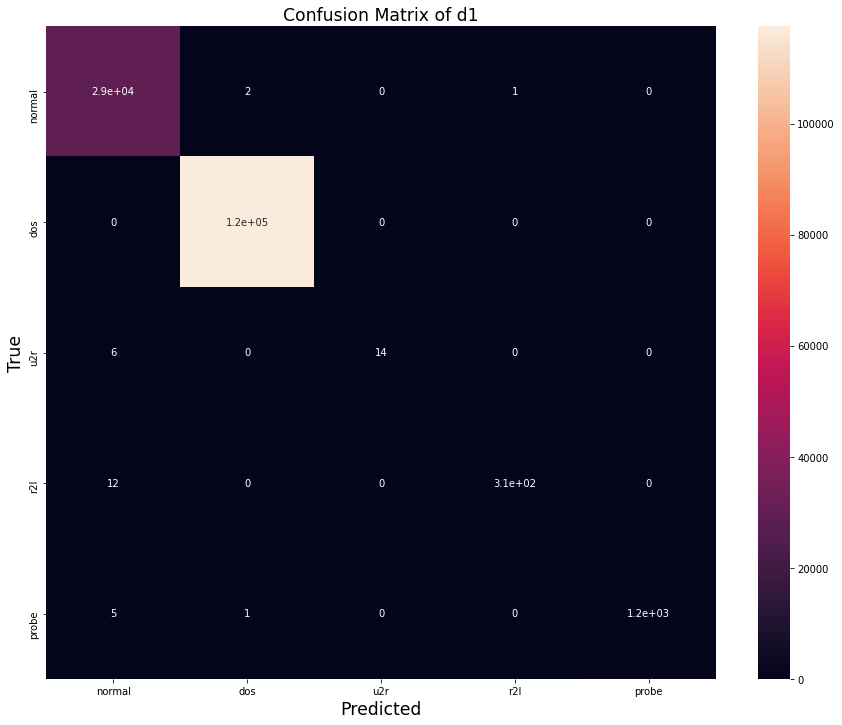

In [53]:
catLst = list(mapCategory.keys())[:-1]
y_pred = rf.predict(x_test)
plotConfMat(y_test,y_pred,"Confusion Matrix of d1",cols=catLst,indx=catLst)

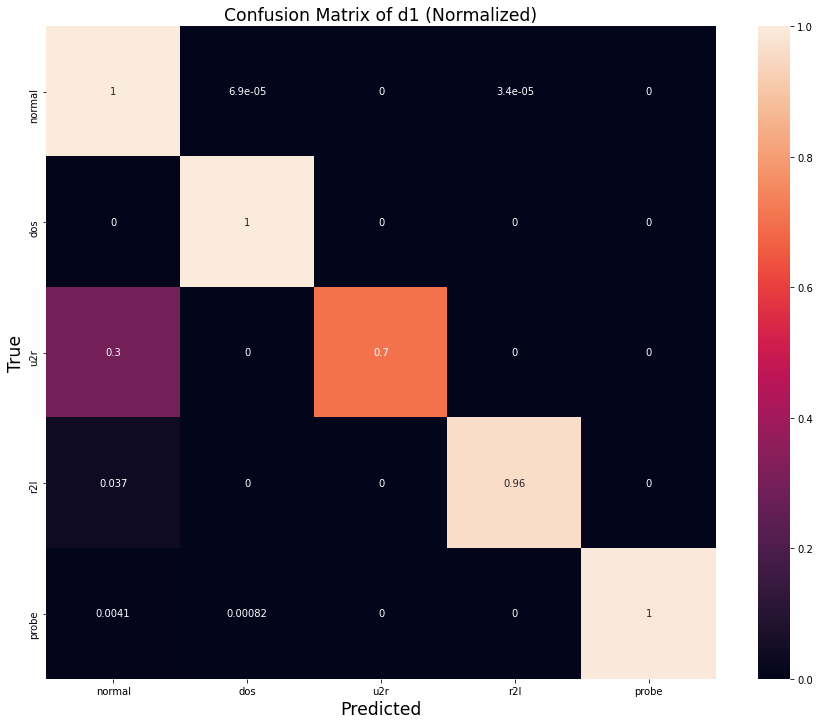

In [54]:
plotConfMat(y_test,y_pred,"Confusion Matrix of d1",True,catLst,catLst)

In [55]:
# y_pred = rf.predict(xT)
# plotConfMat(yT,y_pred,"Confusion Matrix of d2",True)

In [56]:
# y_pred2 = rf2.predict(xT2)
# plotConfMat(yT2,y_pred2,"Using selected features\nConfusion Matrix of d2",True)

## Results
Below, we mentione the results of our experiments. Notice:
- `d1` represents the testing part, $30\%$, of `kddcup.data_10_percent`.
- `d2` represents the other dataset `corrected` which has various unseen attacks
- `d3` represents all the records of `corrected` whose attack type is not present in `kddcup.data_10_percent`. The number of the new attacks is $17$

Also notice 
- $0/1$ means our classifier tries to classify normal, $0$, vs malicious, $1$.
- after map means our classifier tries to classify the traffic to one of the five categories: normal and 5 attack categories. Then, we map it into normal, $0$, vs malicious, $1$.
- Var or variance selection: means eliminating features whose variance is below $0.1$
- Corr: means eliminating one of features whose correlation is above $0.95$
- Corr2: means eliminating one of features whose correlation is above $0.9$
- Balanced: means using class weighting with balanced option
- Balanced2: means using class weighting within each bootstrap sample

### Accuracy

$\phantom{a}$
<table width =100%>
  <tr>
    <th align='center'> Experiment </th>
    <th align='center'> <strong> Accuracy of d1 $(\%)$  </th>
    <th align='center'> <strong> Accuracy of d2 $(\%)$  </th>
    <th align='center'> <strong> Accuracy of d3 $(\%)$  </th>
  </tr>
  <tr>
    <td align='center'> Using all features $[0/1]$</td>
    <td align='center'> $99.98 \%$ </td>
    <td align='center'> $92.87 \%$ </td>
    <td align='center'> $10.9 \%$ </td>
  </tr>
  <tr>
    <td align='center'> All features after map</td>
    <td align='center'> $99.98 \%$ </td>
    <td align='center'> $92.6 \%$ </td>
    <td align='center'> $7.26 \%$ </td>
  </tr>
  <tr>
    <td align='center'> Variance selection $[0/1]$</td>
    <td align='center'> $99.97 \%$ </td>
    <td align='center'> $92.76 \%$ </td>
    <td align='center'> $9.16 \%$ </td>
  </tr>
  <tr>
    <td align='center'> Variance selection after map</td>
    <td align='center'> $99.97 \%$ </td>
    <td align='center'> $92.58 \%$ </td>
    <td align='center'> $8.06 \%$ </td>
  </tr>
  <tr>
    <td align='center'> Var + Corr selection $[0/1]$</td>
    <td align='center'> $99.98 \%$ </td>
    <td align='center'> $92.67 \%$ </td>
    <td align='center'> $9.51 \%$ </td>
  </tr>
  <tr>
    <td align='center'> Var + Corr selection after map</td>
    <td align='center'> $99.98 \%$ </td>
    <td align='center'> $92.49 \%$ </td>
    <td align='center'> $7.41 \%$ </td>
  </tr>
  <tr>
    <td align='center'> Var + Corr2 $[0/1]$</td>
    <td align='center'> $99.98 \%$ </td>
    <td align='center'> $92.56 \%$ </td>
    <td align='center'> $9.79 \%$ </td>
  </tr>
  <tr>
    <td align='center'> Var + Corr2 after map</td>
    <td align='center'> $99.98 \%$ </td>
    <td align='center'> $92.42 \%$ </td>
    <td align='center'> $7.5 \%$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced all features $[0/1]$</td>
    <td align='center'> $99.98 \%$ </td>
    <td align='center'> $92.85 \%$ </td>
    <td align='center'> $10.37 \%$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced selected $[0/1]$</td>
    <td align='center'> $99.98 \%$ </td>
    <td align='center'> $92.71 \%$ </td>
    <td align='center'> $12.06 \%$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced all after map</td>
    <td align='center'> $99.98 \%$ </td>
    <td align='center'> $92.44 \%$ </td>
    <td align='center'> $7.51 \%$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced sel after map</td>
    <td align='center'> $99.97 \%$ </td>
    <td align='center'> $92.40 \%$ </td>
    <td align='center'> $7.36 \%$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced2 all features $[0/1]$</td>
    <td align='center'> $99.98 \%$ </td>
    <td align='center'> $\boldsymbol{92.87 \%}$ </td>
    <td align='center'> $10.45 \%$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced2 selected $[0/1]$</td>
    <td align='center'> $99.98 \%$ </td>
    <td align='center'> $92.67 \%$ </td>
    <td align='center'> $\boldsymbol{12.81 \%}$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced2 all after map</td>
    <td align='center'> $99.98 \%$ </td>
    <td align='center'> $92.36 \%$ </td>
    <td align='center'> $6.12 \%$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced2 sel after map</td>
    <td align='center'> $99.97 \%$ </td>
    <td align='center'> $92.38 \%$ </td>
    <td align='center'> $7.13 \%$ </td>
  </tr>
</table>

### F-Score

$\phantom{a}$
<table width =100%>
  <tr>
    <th align='center'> Experiment </th>
    <th align='center'> <strong> F-Score of d1   </th>
    <th align='center'> <strong> F-Score of d2   </th>
    <th align='center'> <strong> F-Score of d3   </th>
  </tr>
  <tr>
    <td align='center'> Using all features $[0/1]$</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $0.9526$ </td>
    <td align='center'> $0.1496$ </td>
  </tr>
  <tr>
    <td align='center'> All features after map</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $0.9520$ </td>
    <td align='center'> $0.1594$ </td>
  </tr>
  <tr>
    <td align='center'> Variance selection $[0/1]$</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $0.9530$ </td>
    <td align='center'> $0.1708$ </td>
  </tr>
  <tr>
    <td align='center'> Variance selection after map</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $0.9520$ </td>
    <td align='center'> $0.1553$ </td>
  </tr>
  <tr>
    <td align='center'> Var + Corr $[0/1]$</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $0.9519$ </td>
    <td align='center'> $0.1559$ </td>
  </tr>
  <tr>
    <td align='center'> Var + Corr after map</td>
    <td align='center'> $0.9999$ </td>
    <td align='center'> $0.9506$ </td>
    <td align='center'> $0.1361$ </td>
  </tr>
  <tr>
    <td align='center'> Var + Corr2 $[0/1]$</td>
    <td align='center'> $0.9999$ </td>
    <td align='center'> $0.9524$ </td>
    <td align='center'> $0.1942$ </td>
  </tr>
  <tr>
    <td align='center'> Var + Corr2 after map</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $0.9507$ </td>
    <td align='center'> $0.1338$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced all features $[0/1]$</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $0.9536$ </td>
    <td align='center'> $0.1879$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced selected $[0/1]$</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $0.9526$ </td>
    <td align='center'> $0.2153$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced all after map</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $0.9508$ </td>
    <td align='center'> $0.1396$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced sel after map</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $0.9505$ </td>
    <td align='center'> $0.1370$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced2 all features $[0/1]$</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $\boldsymbol{0.9537}$ </td>
    <td align='center'> $0.1892$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced2 selected $[0/1]$</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $0.9524$ </td>
    <td align='center'> $\boldsymbol{0.2270}$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced2 all after map</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $0.9503$ </td>
    <td align='center'> $0.1153$ </td>
  </tr>
  <tr>
    <td align='center'> Balanced2 sel after map</td>
    <td align='center'> $0.9998$ </td>
    <td align='center'> $0.9503$ </td>
    <td align='center'> $0.1330$ </td>
  </tr>
</table>

## Future Work

- Trying to develop heuristics to enhance the model ability to learn the **out of distribution** attacks, new ones.
- Develop semi-supervised learning model with minor data from the unseen attacks
- Developing Neural Network solution as a try to capture more complex features to use it in learning
- Trying to synthesize new records using SMOTE or generative model
- Training mixture of Gaussians and combine it with random forest